## Setup and Dependencies

First, please make sure you are using a GPU runtime to run this notebook, so inference is much faster. If the following command fails, use the `Runtime` menu above and select `Change runtime type`.

In [ ]:
!nvidia-smi

Mon Dec 12 18:33:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install opendatasets==0.1.22
!pip install diffusers==0.9.0
!pip install transformers==4.25.1
!pip install scipy==1.7.3
!pip install ftfy==6.1.1
!pip install "ipywidgets>=7,<8"
!pip install accelerate==0.15.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 453 kB 19.0 MB/s 
     |████████████████████████████████| 182 kB 64.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 24.6 MB/s 
     |████████████████████████████████| 7.6 MB 58.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 26.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-pyth

In [ ]:
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from diffusers import StableDiffusionInpaintPipeline
import PIL
from huggingface_hub import notebook_login
from google.colab import output

In [ ]:
output.enable_custom_widget_manager()

In [ ]:
INPUT_SHAPE = 128

## Login to HuggingFace

To use download the Stable Diffusion model, you need to sign in to https://huggingface.co/ then go to https://huggingface.co/settings/tokens and create
a token. Paste the token below:

In [ ]:
notebook_login()

ValueError: ignored

## Download dataset

The dataset we'll be using for this notebook can be downloaded from Kaggle.com.
Sign into your Kaggle account and then go to http://bit.ly/kaggle-creds to create an API token. Then paste your username and API token below:

In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset", data_dir="./input")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: albrow
Your Kaggle Key: ··········


100%|██████████| 3.79G/3.79G [00:25<00:00, 159MB/s]


In [ ]:
def load_data(path, shape):
    file_names = os.listdir(path)
    file_names.sort()
    if len(file_names) == 0:
      raise ValueError("No files found at path: " + path)

    frame_obj = {
      'img': [],
      'mask': []
    }

    for i, name in enumerate(file_names):
        if not name.endswith('_sat.jpg'):
          continue

        base_name = name.split('_')[0]
        img_path = path + '/' + name
        mask_path = path + '/' + base_name + '_mask.png'
        img = plt.imread(img_path)
        mask = plt.imread(mask_path)

        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frame_obj['img'].append(img)
        # For mask images, only retain channel 0 which represents the mask.
        # Other channels are irrelevant.
        # TODO(albrow): binarize mask with threshold of 128 as recommended on Kaggle?
        frame_obj['mask'].append(mask[:,:,0])

    return frame_obj

In [ ]:
all_data = load_data('./input/deepglobe-road-extraction-dataset/train', shape=INPUT_SHAPE)

In [ ]:
len(all_data['img'])

6226

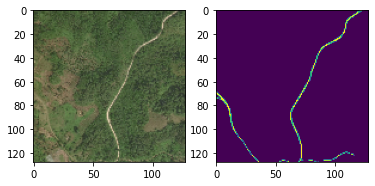

In [ ]:
# Display sample images (helps make sure everything was loaded correctly)
plt.subplot(1,2,1)
plt.imshow(all_data['img'][0])
plt.subplot(1,2,2)
plt.imshow(all_data['mask'][0])
plt.show()

In [ ]:
# Approximately 70/15/15 train/val/test split.
train_data = {'img': np.array(all_data['img'][0:4358]), 'mask': np.array(all_data['mask'][0:4358]) }
val_data = {'img': np.array(all_data['img'][4358:5292]), 'mask': np.array(all_data['mask'][4358:5292]) }
test_data = {'img': np.array(all_data['img'][5292:]), 'mask': np.array(all_data['mask'][5292:]) }

## Configure our U-Net model for image segmentation

We'll use a fairly standard U-Net model for image segmentation. As a reminder,
the model's task is to identify the parts of the image that should be considered
"roads".

In [ ]:
# Define Conv2d block for U-Net
# This block essentially performs 2 convolution

def conv_2d_block(input_tensor, num_filters, kernel_size = 3, do_batch_norm = True):
    # First conv
    x = tf.keras.layers.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),
                              kernel_initializer = 'he_normal', padding = 'same') (input_tensor)

    if do_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    # Second conv
    x = tf.keras.layers.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if do_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x



# Define U-Net
def create_unet(input_image, num_filters = 16, droupouts = 0.1, do_batch_norm = True):
    # defining encoder Path
    c1 = conv_2d_block(input_image, num_filters * 1, kernel_size = 3, do_batch_norm = do_batch_norm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = conv_2d_block(p1, num_filters * 2, kernel_size = 3, do_batch_norm = do_batch_norm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = conv_2d_block(p2, num_filters * 4, kernel_size = 3, do_batch_norm = do_batch_norm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = conv_2d_block(p3, num_filters * 8, kernel_size = 3, do_batch_norm = do_batch_norm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = conv_2d_block(p4, num_filters * 16, kernel_size = 3, do_batch_norm = do_batch_norm)

    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(num_filters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = conv_2d_block(u6, num_filters * 8, kernel_size = 3, do_batch_norm = do_batch_norm)

    u7 = tf.keras.layers.Conv2DTranspose(num_filters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = conv_2d_block(u7, num_filters * 4, kernel_size = 3, do_batch_norm = do_batch_norm)

    u8 = tf.keras.layers.Conv2DTranspose(num_filters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = conv_2d_block(u8, num_filters * 2, kernel_size = 3, do_batch_norm = do_batch_norm)

    u9 = tf.keras.layers.Conv2DTranspose(num_filters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = conv_2d_block(u9, num_filters * 1, kernel_size = 3, do_batch_norm = do_batch_norm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [input_image], outputs = [output])
    return model


## Baseline performance: training on all available samples

First, we'll train the model on the full training set of ~4,000 images.

In [ ]:
# Instantiate and compile model
tf.random.set_seed(42)
np.random.seed(42)
inputs = tf.keras.layers.Input((INPUT_SHAPE, INPUT_SHAPE, 3))
baseline_unet = create_unet(inputs)
baseline_unet.compile(optimizer='Adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryIoU(name="binary_iou"))

In [ ]:
# Note: We're just using the EarlyStopping callback to restore best weights. Because we set the patience very high,
# training will never actually stop early.
restore_best_weights = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=99999999, restore_best_weights=True)
results = baseline_unet.fit(train_data['img'], train_data['mask'], validation_data=(val_data['img'], val_data['mask']), epochs=50, verbose=1, callbacks=[restore_best_weights])

Epoch 1/50
137/137 [==============================] - 27s 108ms/step - loss: 0.3285 - binary_iou: 0.4798 - val_loss: 0.8437 - val_binary_iou: 0.4694
Epoch 2/50
137/137 [==============================] - 14s 99ms/step - loss: 0.1923 - binary_iou: 0.4808 - val_loss: 0.1768 - val_binary_iou: 0.4810
Epoch 3/50
137/137 [==============================] - 14s 100ms/step - loss: 0.1619 - binary_iou: 0.4808 - val_loss: 0.1531 - val_binary_iou: 0.4811
Epoch 4/50
137/137 [==============================] - 14s 102ms/step - loss: 0.1461 - binary_iou: 0.4811 - val_loss: 0.1497 - val_binary_iou: 0.4811
Epoch 5/50
137/137 [==============================] - 14s 104ms/step - loss: 0.1350 - binary_iou: 0.4936 - val_loss: 0.1457 - val_binary_iou: 0.4892
Epoch 6/50
137/137 [==============================] - 14s 103ms/step - loss: 0.1271 - binary_iou: 0.5224 - val_loss: 0.1295 - val_binary_iou: 0.5234
Epoch 7/50
137/137 [==============================] - 14s 102ms/step - loss: 0.1214 - binary_iou: 0.5473 - 

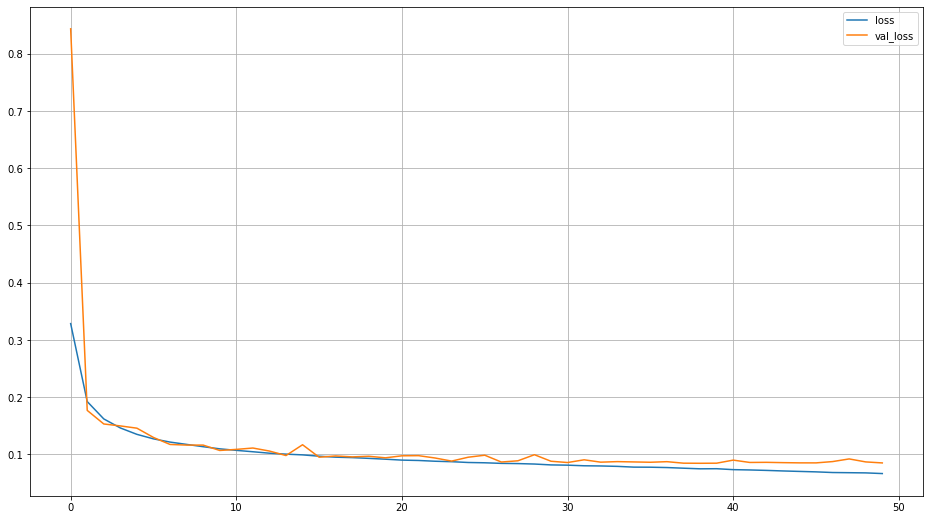

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label='val_loss')
plt.legend()
plt.grid(True)

In [ ]:
baseline_unet.evaluate(test_data['img'], test_data['mask'])

30/30 [==============================] - 1s 28ms/step - loss: 0.0807 - binary_iou: 0.6995


[0.08067069947719574, 0.6995300054550171]

In [ ]:
def batch_predict(model, images, masks):
    images = np.array(images)
    masks = np.array(masks)
    return model.predict(images)


def plot_pred(img, pred_mask, actual_mask):
    plt.figure(figsize=(9,9))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Source Image')

    plt.subplot(1,3,2)
    plt.imshow(pred_mask[:,:,0])
    plt.title('Predicted Roads')

    plt.subplot(1,3,3)
    plt.imshow(actual_mask)
    plt.title('Actual Roads')


In [ ]:
img_batch = test_data['img'][:10]
mask_batch = test_data['mask'][:10]

1/1 [==============================] - 1s 724ms/step


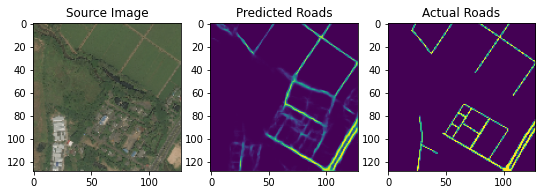

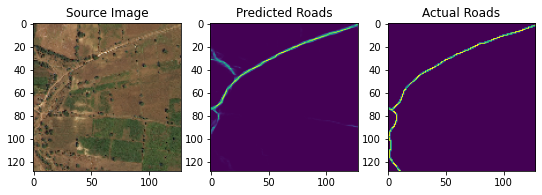

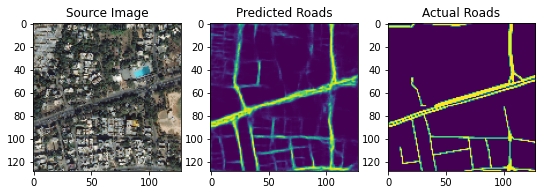

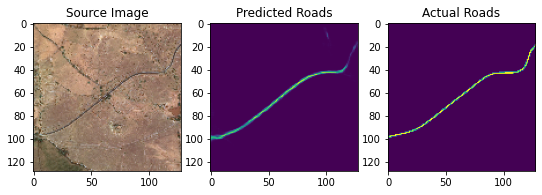

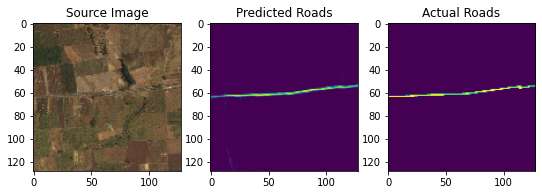

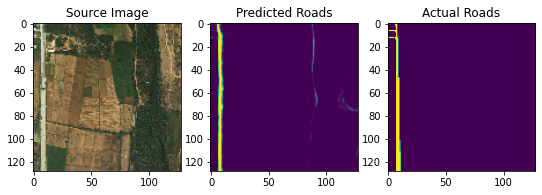

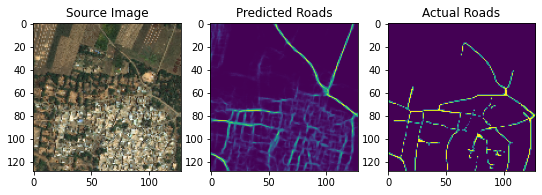

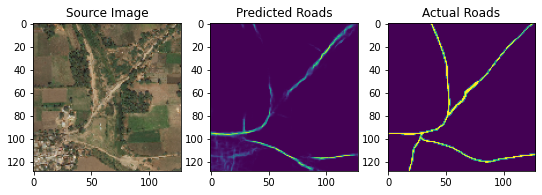

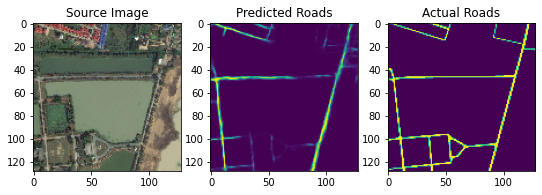

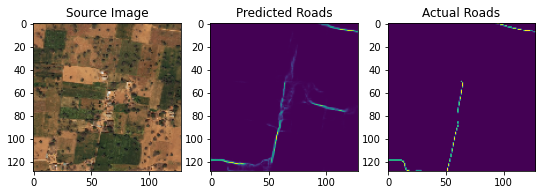

In [ ]:
predictions = batch_predict(baseline_unet, img_batch, mask_batch)
for i, pred in enumerate(predictions):
  plot_pred(img_batch[i], pred, mask_batch[i])

## Simulate limited data by training on fewer samples

In [ ]:
LIMITED_NUM_SAMPLES=100

limited_train_data = {
    'img': train_data['img'][:LIMITED_NUM_SAMPLES],
    'mask': train_data['mask'][:LIMITED_NUM_SAMPLES]
}

In [ ]:
# Instantiate and compile model
tf.random.set_seed(42)
np.random.seed(42)
inputs = tf.keras.layers.Input((INPUT_SHAPE, INPUT_SHAPE, 3))
fewer_samples_unet = create_unet(inputs)
fewer_samples_unet.compile(optimizer='Adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryIoU(name="binary_iou"))

In [ ]:
restore_best_weights = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=99999999, restore_best_weights=True)
results = fewer_samples_unet.fit(limited_train_data['img'], limited_train_data['mask'], validation_data=(val_data['img'], val_data['mask']), epochs=50, verbose=1, callbacks=[restore_best_weights])

Epoch 1/50
4/4 [==============================] - 6s 985ms/step - loss: 0.7701 - binary_iou: 0.2768 - val_loss: 13.1096 - val_binary_iou: 0.0562
Epoch 2/50
4/4 [==============================] - 1s 335ms/step - loss: 0.6623 - binary_iou: 0.3665 - val_loss: 14.3334 - val_binary_iou: 0.0282
Epoch 3/50
4/4 [==============================] - 1s 339ms/step - loss: 0.5694 - binary_iou: 0.4389 - val_loss: 14.4552 - val_binary_iou: 0.0243
Epoch 4/50
4/4 [==============================] - 1s 339ms/step - loss: 0.5070 - binary_iou: 0.4731 - val_loss: 14.4897 - val_binary_iou: 0.0231
Epoch 5/50
4/4 [==============================] - 1s 340ms/step - loss: 0.4596 - binary_iou: 0.4868 - val_loss: 14.4672 - val_binary_iou: 0.0239
Epoch 6/50
4/4 [==============================] - 1s 342ms/step - loss: 0.4186 - binary_iou: 0.4895 - val_loss: 14.4404 - val_binary_iou: 0.0248
Epoch 7/50
4/4 [==============================] - 1s 340ms/step - loss: 0.3875 - binary_iou: 0.4853 - val_loss: 14.4408 - val_bina

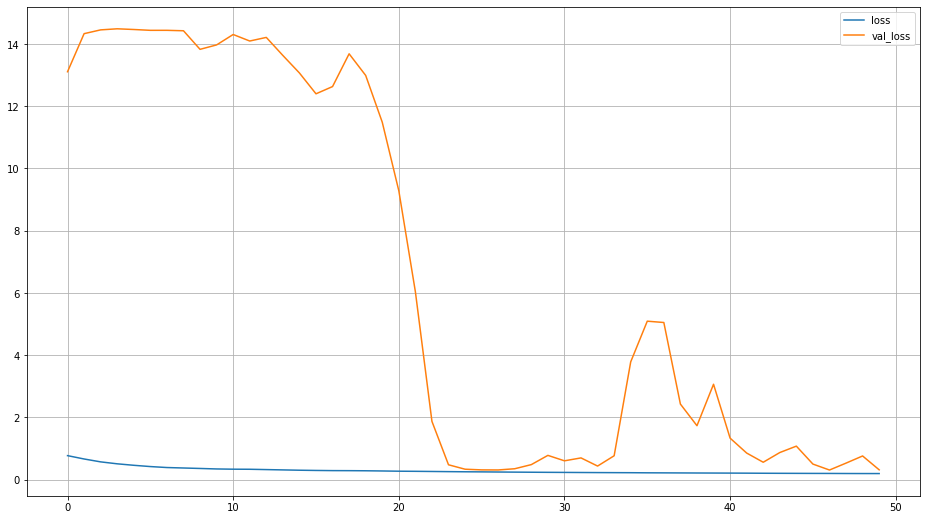

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label='val_loss')
plt.legend()
plt.grid(True)

In [ ]:
fewer_samples_unet.evaluate(test_data['img'], test_data['mask'])

30/30 [==============================] - 1s 28ms/step - loss: 0.3058 - binary_iou: 0.4864


[0.3057745695114136, 0.48640382289886475]

1/1 [==============================] - 0s 377ms/step


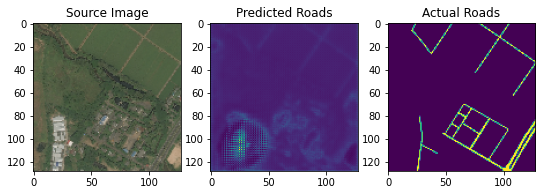

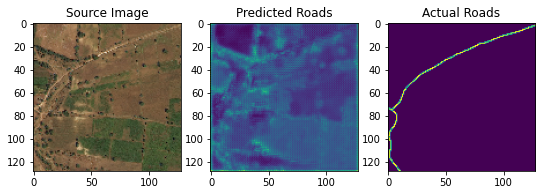

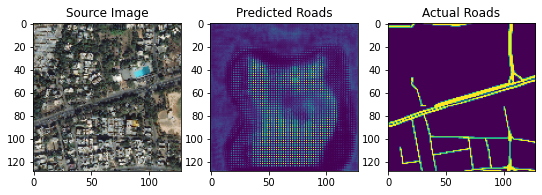

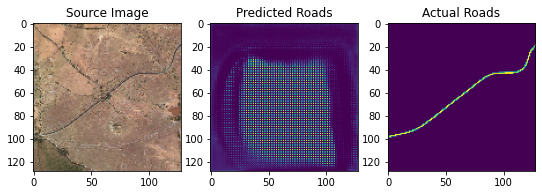

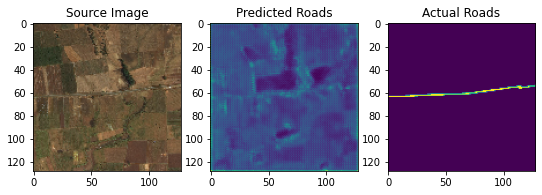

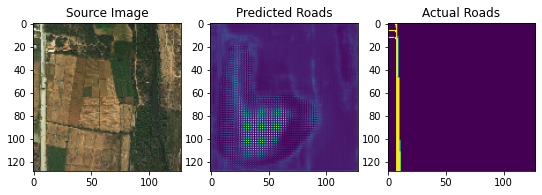

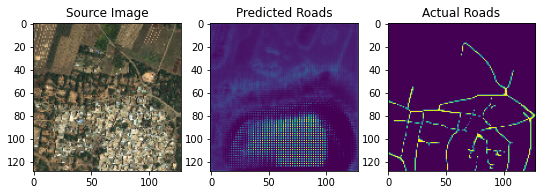

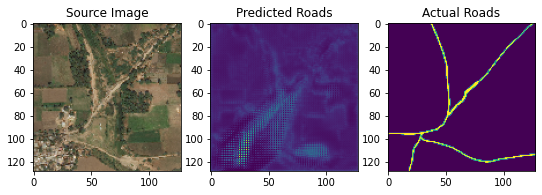

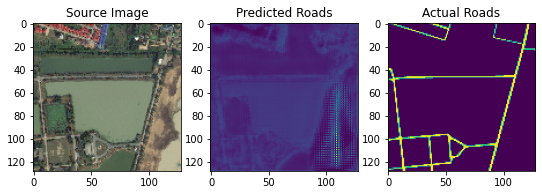

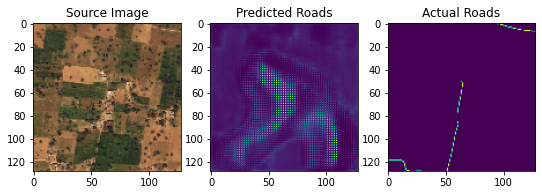

In [ ]:
predictions = batch_predict(fewer_samples_unet, img_batch, mask_batch)
for i, pred in enumerate(predictions):
  plot_pred(img_batch[i], pred, mask_batch[i])

## Augment limited data with SD generated images

In [ ]:
# Load and configure Stable Diffusion inpainting model
pipe = StableDiffusionInpaintPipeline.from_pretrained(
  "runwayml/stable-diffusion-inpainting",
  revision="fp16",
  torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.75k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/287 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/635 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/821 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/810 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/613 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [ ]:
# A helper function which will help us draw images in a grid for comparison and
# manual checking.
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
# Create prompts for image generation.
BACKGROUND_PROMPT = "Overhead aerial photograph of a rural area, 8K, high resolution, satellite image, extremely detailed"
# Note the inclusion of "road" and "highway" in the negative prompt. We don't
# want Stable Diffusion to add any more roads to the image because we are not
# changing the mask during training.
BACKGROUND_NEGATIVE_PROMPT = "road, highway, fisheye"

In [ ]:
def create_image_variant(image_path, mask_path):
  # Use PIL to resize the images to 512x512, the optimal size for Stable
  # Diffusion.
  init_image = PIL.Image.open(image_path).convert("RGB").resize((512, 512))
  mask_image = PIL.Image.open(mask_path).convert("RGB").resize((512, 512))
  # Note we are inverting the mask in this case because we want to re-draw
  # everything that is *not* part of the road.
  inverted_mask = PIL.ImageOps.invert(mask_image)

  # Use Stable Diffusion to re-paint the background scenery.
  gen_background_image = pipe(
    prompt=BACKGROUND_PROMPT,
    negative_prompt=BACKGROUND_NEGATIVE_PROMPT,
    image=init_image,
    mask_image=inverted_mask
  ).images[0]

  # For some reason, this version of Stable Diffusion is not completely
  # respecting the image mask and will distort/repaint portions of the image
  # that it is not supposed to. We can workaround this by re-applying the mask
  # to the generated image.
  # See https://github.com/runwayml/stable-diffusion/issues/5
  final_image = PIL.Image.composite(
    gen_background_image,
    init_image,
    inverted_mask.convert("L")
  )

  return final_image

## Example of generated image variant

Let's quickly generate a varient of one of the training images to make sure it looks right.

In [ ]:
example_image_path = "/content/input/deepglobe-road-extraction-dataset/train/602_sat.jpg"
example_mask_path = "/content/input/deepglobe-road-extraction-dataset/train/602_mask.png"
example_image = PIL.Image.open(example_image_path).convert("RGB").resize((512, 512))
example_mask = PIL.Image.open(example_mask_path).convert("RGB").resize((512, 512))
example_image_variant = create_image_variant(example_image_path, example_mask_path)

  0%|          | 0/50 [00:00<?, ?it/s]

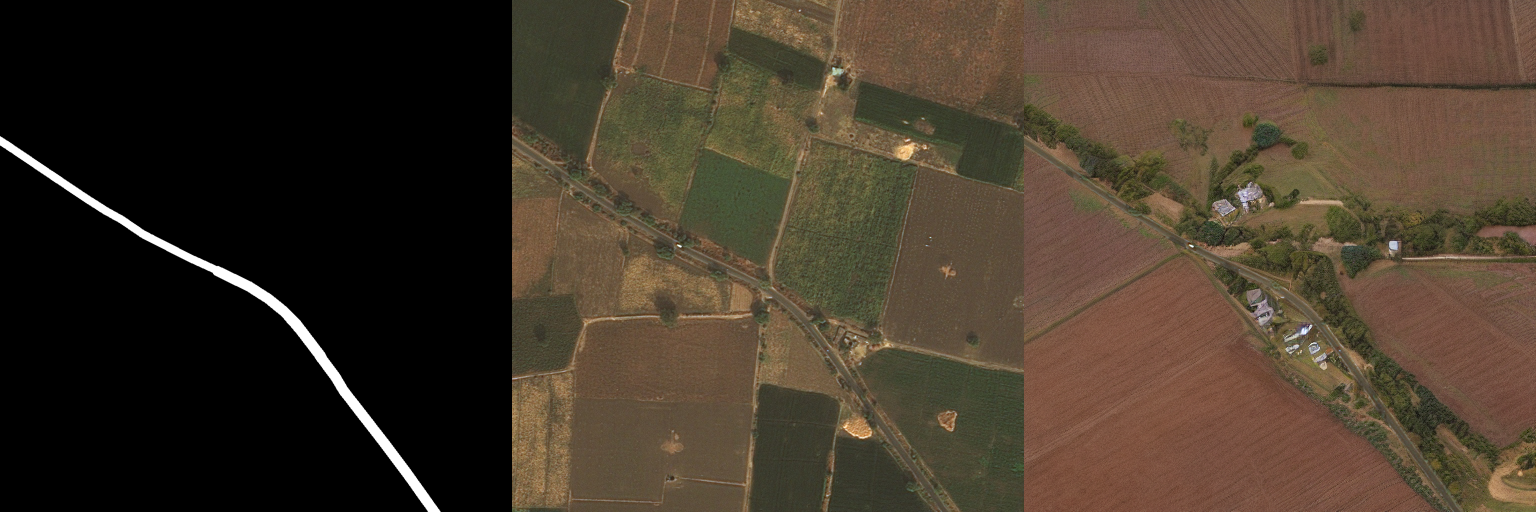

In [ ]:
image_grid([example_mask, example_image, example_image_variant], rows=1, cols=3)

## Adding image variants to the training data

Once we've comfirmed the image variants look correct, let's agument our limited training dataset by adding generated images to it.

In [ ]:
def create_variants_from_path(input_path, output_path, limit_source_images=LIMITED_NUM_SAMPLES, variants_per_image=1):
    file_names = os.listdir(input_path)
    if len(file_names) == 0:
      raise ValueError("No files found at path: " + input_path)

    try:
      os.mkdir(output_path)
    except(FileExistsError):
      print("Warn: directory already exists. This might mean we are overwriting existing images.")

    counter = 0
    for i, name in enumerate(file_names):
      if not name.endswith('_sat.jpg'):
        continue
      if counter >= limit_source_images:
        break
      counter += 1

      print(f"Generating variants for source image {counter}/{limit_source_images}")

      base_name = name.split('_')[0]
      img_path = input_path + '/' + name
      mask_path = input_path + '/' + base_name + '_mask.png'

      for i in range(variants_per_image):

        # Generate and save image variant
        img_variant = create_image_variant(img_path, mask_path)
        img_variant.save(f"{output_path}{base_name}-variant-{i}_sat.jpg")

        # Save mask in new location to match the folder structure expected
        # by load_data.
        mask_image = PIL.Image.open(mask_path).convert("RGB").resize((512, 512))
        mask_image.save(f"{output_path}{base_name}-variant-{i}_mask.png")

In [ ]:
# You can change the variants_per_image argument to generate more images. Be
# warned that generating more images can take a long time.
create_variants_from_path("/content/input/deepglobe-road-extraction-dataset/train/", "/content/generated/", variants_per_image=1)

Generating variants for source image 1/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 2/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 3/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 4/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 5/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 6/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 7/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 8/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 9/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 10/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 11/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 12/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 13/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 14/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 15/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 16/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 17/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 18/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 19/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 20/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 21/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 22/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 23/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 24/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 25/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 26/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 27/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 28/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 29/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 30/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 31/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 32/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 33/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 34/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 35/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 36/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 37/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 38/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 39/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 40/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 41/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 42/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 43/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 44/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 45/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 46/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 47/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 48/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 49/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 50/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 51/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 52/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 53/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 54/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 55/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 56/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 57/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 58/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 59/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 60/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 61/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 62/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 63/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 64/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 65/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 66/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 67/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 68/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 69/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 70/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 71/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 72/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 73/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 74/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 75/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 76/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 77/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 78/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 79/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 80/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 81/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 82/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 83/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 84/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 85/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 86/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 87/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 88/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 89/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 90/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 91/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 92/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 93/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 94/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 95/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 96/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 97/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 98/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 99/100


  0%|          | 0/50 [00:00<?, ?it/s]

Generating variants for source image 100/100


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
generated_data = load_data('/content/generated/', shape=INPUT_SHAPE)

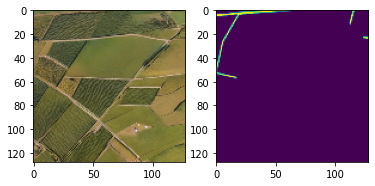

In [ ]:
# Display sample images from generated data (helps make sure everything was loaded correctly)
plt.subplot(1,2,1)
plt.imshow(generated_data['img'][0])
plt.subplot(1,2,2)
plt.imshow(generated_data['mask'][0])
plt.show()

In [ ]:
augmented_train_data = {
    'img': np.concatenate([generated_data['img'], limited_train_data['img']]),
    'mask': np.concatenate([generated_data['mask'], limited_train_data['mask']]),
}

In [ ]:
len(augmented_train_data['img'])

200

## Train on augmented data and compare performance

In [ ]:
# Instantiate and compile model
tf.random.set_seed(42)
np.random.seed(42)
inputs = tf.keras.layers.Input((INPUT_SHAPE, INPUT_SHAPE, 3))
augmented_samples_unet = create_unet(inputs)
augmented_samples_unet.compile(optimizer='Adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryIoU(name="binary_iou"))

In [ ]:
restore_best_weights = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=99999999, restore_best_weights=True)
results = augmented_samples_unet.fit(augmented_train_data['img'], augmented_train_data['mask'], validation_data=(val_data['img'], val_data['mask']), epochs=50, verbose=1, callbacks=[restore_best_weights])

Epoch 1/50
7/7 [==============================] - 6s 472ms/step - loss: 0.7354 - binary_iou: 0.2996 - val_loss: 13.9574 - val_binary_iou: 0.0409
Epoch 2/50
7/7 [==============================] - 1s 216ms/step - loss: 0.5769 - binary_iou: 0.4286 - val_loss: 14.3919 - val_binary_iou: 0.0266
Epoch 3/50
7/7 [==============================] - 1s 217ms/step - loss: 0.4737 - binary_iou: 0.4813 - val_loss: 14.4366 - val_binary_iou: 0.0250
Epoch 4/50
7/7 [==============================] - 1s 217ms/step - loss: 0.4107 - binary_iou: 0.4859 - val_loss: 14.4375 - val_binary_iou: 0.0250
Epoch 5/50
7/7 [==============================] - 1s 218ms/step - loss: 0.3742 - binary_iou: 0.4898 - val_loss: 14.3291 - val_binary_iou: 0.0288
Epoch 6/50
7/7 [==============================] - 1s 218ms/step - loss: 0.3478 - binary_iou: 0.4864 - val_loss: 14.3208 - val_binary_iou: 0.0291
Epoch 7/50
7/7 [==============================] - 1s 223ms/step - loss: 0.3277 - binary_iou: 0.4855 - val_loss: 13.9452 - val_bina

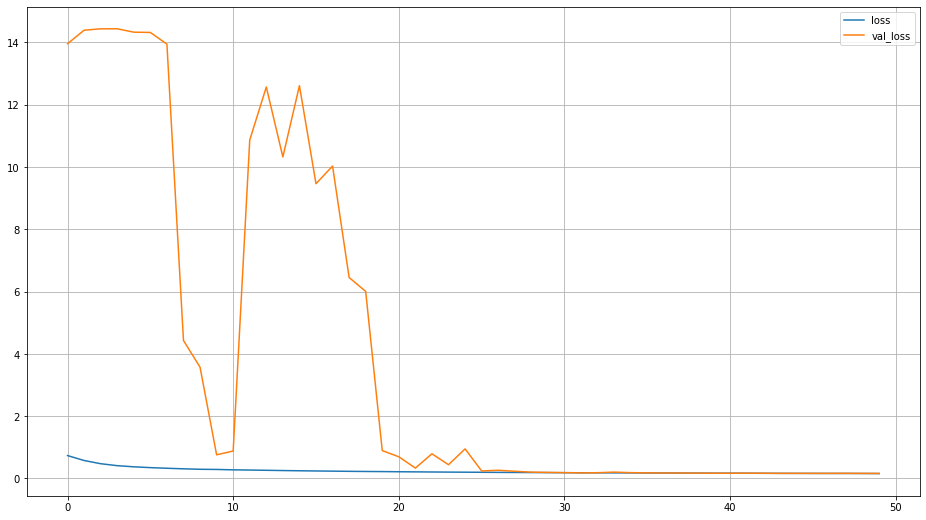

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label='val_loss')
plt.legend()
plt.grid(True)

In [ ]:
augmented_samples_unet.evaluate(test_data['img'], test_data['mask'])

30/30 [==============================] - 1s 28ms/step - loss: 0.1557 - binary_iou: 0.4818


[0.15569889545440674, 0.48177382349967957]

1/1 [==============================] - 0s 357ms/step


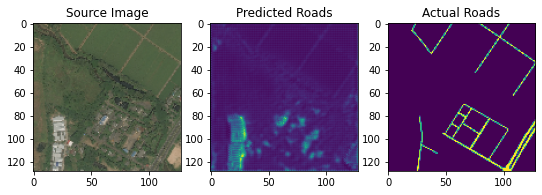

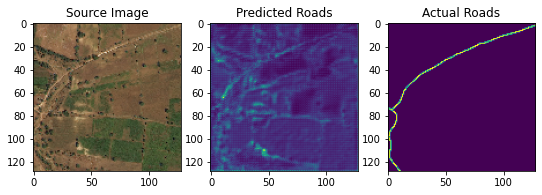

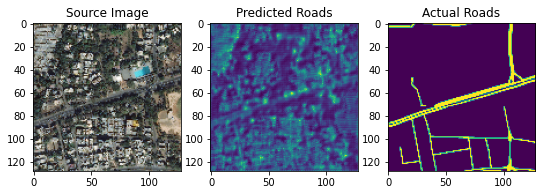

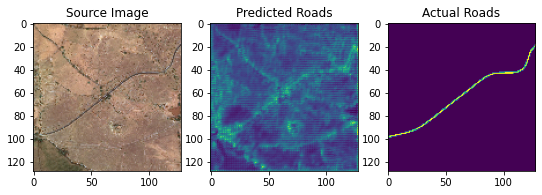

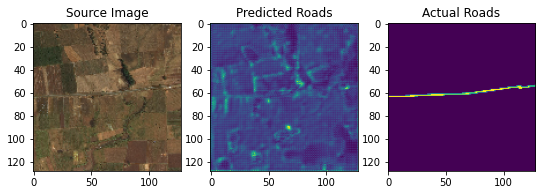

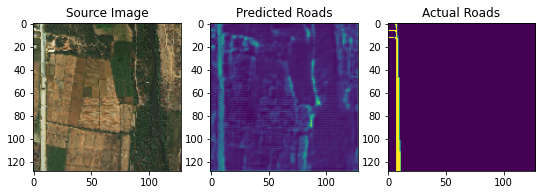

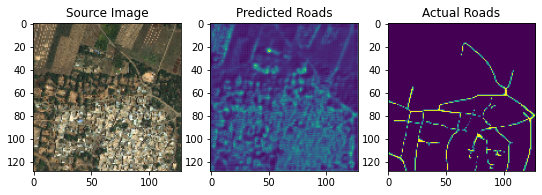

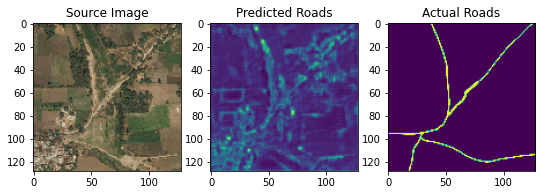

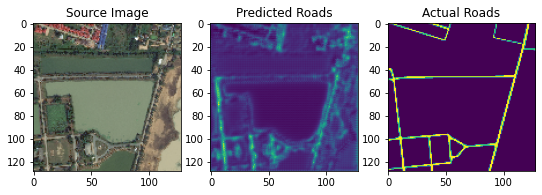

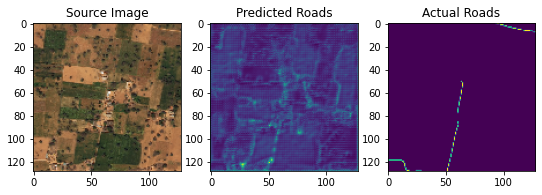

In [ ]:
predictions = batch_predict(augmented_samples_unet, img_batch, mask_batch)
for i, pred in enumerate(predictions):
  plot_pred(img_batch[i], pred, mask_batch[i])